<a href="https://www.kaggle.com/code/nigamshitij/fa-framework-to-deploy-neural-network?scriptVersionId=177004648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# boilerplate imports
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
from fastai.tabular.all import *

# set formatting options
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

# read from csv
dataframe = pd.read_csv(path/'train.csv')
# dataframe.head()

# # add features
def add_features(dataframe):
    dataframe['LogFare'] = np.log1p(dataframe['Fare'])
    dataframe['Deck'] = dataframe['Cabin'].str[0].map(dict(A = "ABC", B = "ABC", C = "ABC", D = "DE", E = "DE", F = "FG", G = "FG")) # group decks
    dataframe['Family'] = dataframe['SibSp'] + dataframe['Parch']
    dataframe['Alone'] = dataframe['Family'] == 0
    dataframe['TicketFreq'] = dataframe.groupby('Ticket')['Ticket'].transform('count')
    dataframe['Title'] = dataframe['Name'].str.split(', ', expand = True)[1].str.split('.', expand = True)[0] # first part removes last name, second part extracts mr/mrs
    dataframe['Title'] = dataframe.Title.map(dict(Mr = "Mr", Miss = "Miss", Mrs = "Mrs", Master = "Master"))

add_features(dataframe)
dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr


In [5]:
# split data
splits = RandomSplitter(seed = 42)(dataframe)

# build a dataloader for batching purposes
dataloaders = TabularPandas(
    dataframe,
    splits = splits, # get indexes for training and validation
    procs = [Categorify, FillMissing, Normalize], # turn strings into categories, fill missing values in numeric w/ median, normalize all numeric columns
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'], # categorical variables (independent)
    cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'], # continuous variables (independent)
    y_names = 'Survived', # dependent variable
    y_block = CategoryBlock() # build a classification model, not regression
).dataloaders(path = '.')

# build a learner
learner = tabular_learner(dataloaders, metrics = accuracy, layers = [10, 10])

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


SuggestedLRs(slide=0.04786301031708717, valley=0.009120108559727669)

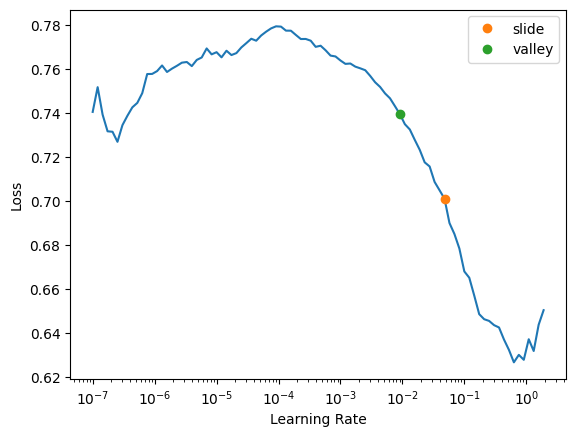

In [6]:
# find sample learning rates
learner.lr_find(suggest_funcs = (slide, valley))

In [7]:
learner.fit(n_epoch = 16, lr = 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.547859,0.590293,0.640449,00:00
1,0.508080,0.481418,0.803371,00:00
2,0.469510,0.442730,0.808989,00:00
3,0.449098,0.450369,0.842697,00:00
4,0.417549,0.428384,0.814607,00:00
5,0.415517,0.440584,0.848315,00:00
6,0.401478,0.438075,0.820225,00:00
7,0.396373,0.491749,0.775281,00:00
8,0.401140,0.465741,0.820225,00:00
9,0.392440,0.433571,0.848315,00:00


In [8]:
# generate csv for export

# get test
test_dataframe = pd.read_csv(path/'test.csv')
test_dataframe['Fare'] = test_dataframe['Fare'].fillna(0)

# add similar features
add_features(test_dataframe)
test_dataframe.head()

# create test dataloader
test_dataloader = learner.dls.test_dl(test_dataframe)
predictions, _ = learner.get_preds(dl = test_dataloader)

# add survived column based on predictions
test_dataframe['Survived'] = (predictions[:, 1]> 0.5).int()
submission_dataframe = test_dataframe[['PassengerId', 'Survived']]
submission_dataframe.to_csv('sub.csv', index = False)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [9]:
# !head sub.csv
learner.no_bar??
learner.no_logging??

Signature: learner.no_logging()
Docstring: Context manager to temporarily remove `logger`
Source:   
    @contextmanager
    def no_logging(self): return replacing_yield(self, 'logger', noop)
File:      /opt/conda/lib/python3.10/site-packages/fastai/learner.py
Type:      method

In [10]:
def ensemble():
    learner = tabular_learner(dataloaders, metrics = accuracy, layers = [10, 10])
    with learner.no_bar(), learner.no_logging():
        learner.fit(n_epoch = 16, lr = 0.03)
    return learner.get_preds(dl = test_dataloader)[0]

learners = [ensemble() for _ in range(5)]

In [11]:
ensemble_predictions = torch.stack(learners).mean(0)

test_dataframe['Survived'] = (ensemble_predictions[:,1]>0.5).int()
submission_dataframe = test_dataframe[['PassengerId', 'Survived']]
submission_dataframe.to_csv('sub.csv', index = False)

!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
